# Assignment 1 - Income Prediction

In this notebook, I will report how I process the data, compare the performance of different algorithms, and tune the parameters based on the best algorithm.

I compared the performance of seven algorithms on this task: Gradient Tree Boosting,Decision Tree,XGBoost,Random Forest,SVM,Light GBM,Naive Bayes. And the algorithm that I found to work best on this task was XGBoost.  

## Data Processing

In [2]:
#Load data

import pandas as pd
import numpy as np

data_training=pd.read_csv('census-income-training.csv',header=0)
data_test=pd.read_csv('census-income-test.csv',header=0)

display(data_training.head(n=5))

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,...,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,year,income_morethan_50K,Id
0,49,Private,43,2,Doctorate degree(PhD EdD),0,Not in universe,Married-civilian spouse present,Education,Executive admin and managerial,...,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,94,1,1
1,49,Private,45,12,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Other professional services,Professional specialty,...,United-States,United-States,Native- Born in the United States,0,No,1,30,95,0,2
2,49,Private,12,26,High school graduate,0,Not in universe,Married-civilian spouse present,Manufacturing-durable goods,Adm support including clerical,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0,3
3,38,Private,3,34,High school graduate,0,Not in universe,Married-civilian spouse present,Mining,Precision production craft & repair,...,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,94,0,5
4,46,Not in universe,0,0,Masters degree(MA MS MEng MEd MSW MBA),0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,0,6


I found there were "? "in these columns below,so I delete these columns.
In addition, I found that all values were the same in column PARENT, so I delete this column too.

In [3]:
#Split the data into features and target label and drop invalid feature

invalid_feature = 'GRINREG','MIGMTR1','MIGMTR3','MIGSAME','PARENT','PEFNTVTY','PEMNTVTY','PENATVTY'
income_raw_training = data_training['income_morethan_50K']
features_raw_training = data_training.drop(['income_morethan_50K','Id','GRINREG','MIGMTR1','MIGMTR3','MIGSAME','PARENT','PEFNTVTY','PEMNTVTY','PENATVTY'],axis=1)
features_raw_test = data_test.drop(['Id','GRINREG','MIGMTR1','MIGMTR3','MIGSAME','PARENT','PEFNTVTY','PEMNTVTY','PENATVTY'],axis=1)

I find some values tend to lie near a single number, or whose values have a non-trivial number of vastly larger or smaller values than that single number. 
So I apply a logarithmic transformation on the data so that the very large and very small values do not negatively affect the performance of the learning algorithms.
Since the logarithm of 0 is undefined, I use a logarithmic transformation with an addition by a small amount above 0.

In [4]:
#Transforming Skewed Continuous Features
skewed = ['AHRSPAY','CAPGAIN', 'CAPLOSS','DIVVAL']
features_log_transformed_training = pd.DataFrame(features_raw_training)
features_log_transformed_training[skewed] = features_raw_training[skewed].apply(lambda x: np.log(x + 1))
features_log_transformed_test = pd.DataFrame(features_raw_test)
features_log_transformed_test[skewed] = features_raw_test[skewed].apply(lambda x: np.log(x + 1))

The values of some discrete variables vary a lot, so I implement a normalization procedure.

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
numerical = ['AAGE', 'ADTOCC', 'AHRSPAY', 'CAPGAIN','CAPLOSS', 'DIVVAL','HHDREL','NOEMP']
features_log_minmax_transform_training = pd.DataFrame(features_log_transformed_training)
features_log_minmax_transform_training[numerical] = scaler.fit_transform(features_log_transformed_training[numerical])
features_log_minmax_transform_test = pd.DataFrame(features_log_transformed_test)
features_log_minmax_transform_test[numerical] = scaler.fit_transform(features_log_transformed_test[numerical])

I use a one-hot encoding procedure to create a "dummy" variable for each possible category of each non-numeric feature.

In [6]:
#Convert Categorical Variables
features_training_final = pd.get_dummies(features_log_minmax_transform_training)
features_test_final = pd.get_dummies(features_log_minmax_transform_test)
income_training_final= income_raw_training

In [ ]:
display(data_training.head(n=5))  

## Compare the performance of each algorithm: GTB,Desicion Tree,Xgboost,Random forest,SVM,Naive Bayes

I first used train data to compare the performance of each algorithm.

In [7]:
#Split the Data into Training and Test Sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features_training_final,income_training_final,test_size = 0.2,random_state = 0)

In [9]:
#GTB
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

GTB = GradientBoostingClassifier()
GTB.fit(x_train,y_train)
GTB_y_predict=GTB.predict(x_test)
GTB.score(x_test,y_test)

print('score of Desicion Tree')
print(GTB.score(x_test,y_test))

from sklearn.metrics import classification_report
print('Prediction accuracy of GTB')
print(classification_report(y_test,GTB_y_predict))

score of Desicion Tree
0.9345186014769188
Prediction accuracy of GTB
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     26029
           1       0.75      0.40      0.52      2544

    accuracy                           0.93     28573
   macro avg       0.85      0.69      0.74     28573
weighted avg       0.93      0.93      0.93     28573



In [16]:
#Desicion Tree
from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt.fit(x_train,y_train)
dt_y_predict=dt.predict(x_test)
dt.score(x_test,y_test)

print('score of Desicion Tree')
print(dt.score(x_test,y_test))

print('Prediction accuracy of Desicion Tree')
print(classification_report(y_test,dt_y_predict))

score of Desicion Tree
0.9059601721905295
Prediction accuracy of Desicion Tree
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     26029
           1       0.47      0.48      0.48      2544

    accuracy                           0.91     28573
   macro avg       0.71      0.71      0.71     28573
weighted avg       0.91      0.91      0.91     28573



In [12]:
#Xgboost
from xgboost import XGBClassifier
xgbc=XGBClassifier()
xgbc.fit(x_train,y_train)
xgbc_y_predict=xgbc.predict(x_test)
xgbc.score(x_test,y_test)

print('score of XGBoost')
print(xgbc.score(x_test,y_test))

print('Prediction accuracy of XGBoost')
print(classification_report(y_test,xgbc_y_predict))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:39:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
score of XGBoost
0.940083295418752
Prediction accuracy of XGBoost
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     26029
           1       0.77      0.47      0.58      2544

    accuracy                           0.94     28573
   macro avg       0.86      0.73      0.77     28573
weighted avg       0.93      0.94      0.93     28573



In [18]:
#Random forest
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()
rfc.fit(x_train,y_train)
rfc_y_predict=rfc.predict(x_test)
rfc.score(x_test,y_test)

print('score of random forest')
print(rfc.score(x_test,y_test))

print('Prediction accuracy of random forest')
print(classification_report(y_test,rfc_y_predict))

score of random forest
0.934448605326707
Prediction accuracy of random forest
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     26029
           1       0.75      0.39      0.52      2544

    accuracy                           0.93     28573
   macro avg       0.85      0.69      0.74     28573
weighted avg       0.93      0.93      0.92     28573



In [ ]:
#SVM
from sklearn import svm
svm = svm.SVC()
svm.fit(x_train, y_train)
svm_y_predict=svm.predict(x_test)
svm.score(x_train, y_train)

print('score of SVM')
print(svm.score(x_train, y_train) )

print('Prediction accuracy of SVM')
print(classification_report(y_test, svm_y_predict))

In [10]:
#Naive Bayes
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB()
MNB.fit(x_train,y_train)
MNB_y_predict=MNB.predict(x_test)
MNB.score(x_test,y_test)

print('score of Desicion Tree')
print(MNB.score(x_test,y_test))

print('Prediction accuracy of Bayesian Network')
print(classification_report(y_test,MNB_y_predict))

score of Desicion Tree
0.6590487523186225
Prediction accuracy of Bayesian Network
              precision    recall  f1-score   support

           0       0.98      0.64      0.77     26029
           1       0.19      0.86      0.31      2544

    accuracy                           0.66     28573
   macro avg       0.58      0.75      0.54     28573
weighted avg       0.91      0.66      0.73     28573



I also tried another algorithm Light GBM, but didn't include it in the comparison because it was a simple GTB.

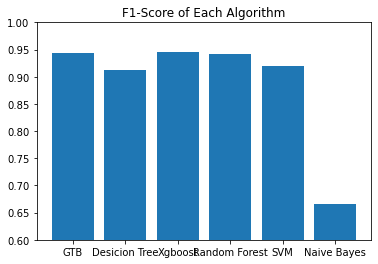

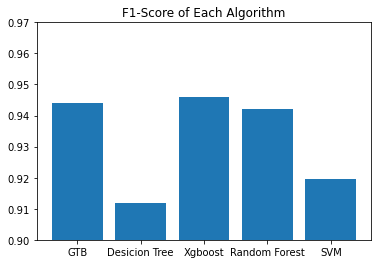

In [22]:
#The Performance of Each Algorithm
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

num_list_score =[0.9439988116458705,0.9119132501485443,0.9459298871063577,0.9422162804515746,0.9197118241235889,0.6665181224004754]
name_list_score=['GTB','Desicion Tree','Xgboost','Random Forest','SVM','Naive Bayes']
plt.bar(range(len(num_list_score)),num_list_score,tick_label=name_list_score)
plt.title('F1-Score of Each Algorithm')
plt.ylim(0.6,1)
plt.show() 


num_list_score =[0.9439988116458705,0.9119132501485443,0.9459298871063577,0.9422162804515746,0.9197118241235889]
name_list_score=['GTB','Desicion Tree','Xgboost','Random Forest','SVM']
plt.bar(range(len(num_list_score)),num_list_score,tick_label=name_list_score)
plt.title('F1-Score of Each Algorithm')
plt.ylim(0.9,0.97)
plt.show() 

#According to the score and accuracy of each algorithm,I found XGBoost to be the best.
#Next, I'll use the XGBoost algorithm for further analysis.


After discussion with my teammates, I tried to label the missing value NA as a specific label for analysis.  
the codes are as follows.  
data_training_clean=data_training.replace(regex=[r'\?'],value=np.nan)  
data_training=data_training_clean.fillna(0)  
But it turns out that the prediction effect is not as good as deleting these columns.  
Therefore, in the subsequent analysis, I will adopt the original data processing method.

## Tune the Parameter 

I used GridSearchCV to test the best parameters.  
I test the optimal values for max_depth, min_child_weight,gamma,subsample,colsample_bytree

In [13]:
#View default Values
print(xgbc)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [14]:
#max_depth 和min_child_weight
from sklearn.model_selection import GridSearchCV
param_test1 = {
 'max_depth':list(range(3,10,2)),
 'min_child_weight':list(range(1,6,2))
}
gsearch1 = GridSearchCV(estimator = XGBClassifier

                        (base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None), 
                        
              param_grid = param_test1, scoring='roc_auc',n_jobs=4,refit=False, cv=5)

gsearch1.fit(x_train,y_train)
means = gsearch1.cv_results_['mean_test_score']
params = gsearch1.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))

0.931658  with:   {'max_depth': 3, 'min_child_weight': 1}
0.931186  with:   {'max_depth': 3, 'min_child_weight': 3}
0.931381  with:   {'max_depth': 3, 'min_child_weight': 5}
0.933628  with:   {'max_depth': 5, 'min_child_weight': 1}
0.933523  with:   {'max_depth': 5, 'min_child_weight': 3}
0.933353  with:   {'max_depth': 5, 'min_child_weight': 5}
0.932391  with:   {'max_depth': 7, 'min_child_weight': 1}
0.932581  with:   {'max_depth': 7, 'min_child_weight': 3}
0.932435  with:   {'max_depth': 7, 'min_child_weight': 5}
0.929587  with:   {'max_depth': 9, 'min_child_weight': 1}
0.930405  with:   {'max_depth': 9, 'min_child_weight': 3}
0.930731  with:   {'max_depth': 9, 'min_child_weight': 5}


a better value of max_depth is 5 ,and a better value of min_child_weight is 1

In [17]:
#max_depth 和min_child_weight again
param_test2 = {
 'max_depth':list(range(3,6,1)),
 'min_child_weight':list(range(1,4,1))
}
gsearch2 = GridSearchCV(estimator = XGBClassifier

                        (base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None), 
                        
              param_grid = param_test2, scoring='roc_auc',n_jobs=4,refit=False, cv=5)
                        
gsearch2.fit(x_train,y_train)
means = gsearch2.cv_results_['mean_test_score']
params = gsearch2.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))

0.931658  with:   {'max_depth': 3, 'min_child_weight': 1}
0.931469  with:   {'max_depth': 3, 'min_child_weight': 2}
0.931186  with:   {'max_depth': 3, 'min_child_weight': 3}
0.932864  with:   {'max_depth': 4, 'min_child_weight': 1}
0.933689  with:   {'max_depth': 4, 'min_child_weight': 2}
0.933059  with:   {'max_depth': 4, 'min_child_weight': 3}
0.933628  with:   {'max_depth': 5, 'min_child_weight': 1}
0.933618  with:   {'max_depth': 5, 'min_child_weight': 2}
0.933523  with:   {'max_depth': 5, 'min_child_weight': 3}


a better value of max_depth is 4 ,and a better value of min_child_weight is 2

In [18]:
#gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,6)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier

                        (base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=2,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None), 
                        
              param_grid = param_test3, scoring='roc_auc',n_jobs=4,refit=False, cv=5)

gsearch3.fit(x_train,y_train)
means = gsearch3.cv_results_['mean_test_score']
params = gsearch3.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))

0.933689  with:   {'gamma': 0.0}
0.933320  with:   {'gamma': 0.1}
0.933088  with:   {'gamma': 0.2}
0.933113  with:   {'gamma': 0.3}
0.933252  with:   {'gamma': 0.4}
0.932950  with:   {'gamma': 0.5}


a better value of gamma is 0

In [19]:
#subsample,colsample_bytree
param_test4 = {
 'subsample':[i/100.0 for i in range(75,100,5)],
 'colsample_bytree':[i/100.0 for i in range(75,100,5)]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier

                        (base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=2,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None), 
                        
              param_grid = param_test4, scoring='roc_auc',n_jobs=4,refit=False, cv=5)

gsearch4.fit(x_train,y_train)
means = gsearch4.cv_results_['mean_test_score']
params = gsearch4.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))

0.932468  with:   {'colsample_bytree': 0.75, 'subsample': 0.75}
0.933095  with:   {'colsample_bytree': 0.75, 'subsample': 0.8}
0.933492  with:   {'colsample_bytree': 0.75, 'subsample': 0.85}
0.933316  with:   {'colsample_bytree': 0.75, 'subsample': 0.9}
0.933004  with:   {'colsample_bytree': 0.75, 'subsample': 0.95}
0.933095  with:   {'colsample_bytree': 0.8, 'subsample': 0.75}
0.933183  with:   {'colsample_bytree': 0.8, 'subsample': 0.8}
0.933074  with:   {'colsample_bytree': 0.8, 'subsample': 0.85}
0.933166  with:   {'colsample_bytree': 0.8, 'subsample': 0.9}
0.932996  with:   {'colsample_bytree': 0.8, 'subsample': 0.95}
0.932922  with:   {'colsample_bytree': 0.85, 'subsample': 0.75}
0.932943  with:   {'colsample_bytree': 0.85, 'subsample': 0.8}
0.933233  with:   {'colsample_bytree': 0.85, 'subsample': 0.85}
0.933251  with:   {'colsample_bytree': 0.85, 'subsample': 0.9}
0.932665  with:   {'colsample_bytree': 0.85, 'subsample': 0.95}
0.933161  with:   {'colsample_bytree': 0.9, 'subsam

'colsample_bytree': 0.75, 'subsample': 0.85

The model after parameter tuning is shown below

In [20]:
xgbc=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=2,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.85,
              tree_method='exact', validate_parameters=1, verbosity=None)

xgbc.fit(x_train,y_train)
xgbc_y_predict=xgbc.predict(x_test)
xgbc.score(x_test,y_test)
print('score of XGBoost')
print(xgbc.score(x_test,y_test))

print('Prediction accuracy of XGBoost')
print(classification_report(y_test,xgbc_y_predict))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:26:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
score of XGBoost
0.9389633570153642
Prediction accuracy of XGBoost
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     26029
           1       0.76      0.46      0.57      2544

    accuracy                           0.94     28573
   macro avg       0.85      0.72      0.77     28573
weighted avg       0.93      0.94      0.93     28573



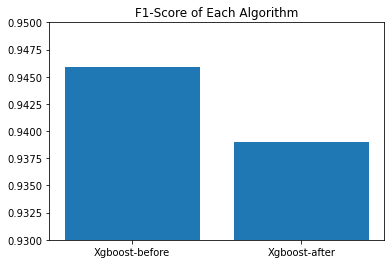

In [24]:
#Compare the performance before and after tuning

num_list_score =[0.9459298871063577,0.9389633570153642]
name_list_score=['Xgboost-before','Xgboost-after']
plt.bar(range(len(num_list_score)),num_list_score,tick_label=name_list_score)
plt.title('F1-Score of Each Algorithm')
plt.ylim(0.93,0.95)
plt.show() 


After selecting the optimal algorithm and adjusting the relevant parameters, we use this model for prediction,the code are as follow

In [ ]:
#Prediction

xgbc=XGBClassifier()

xgbc.fit(x_train,y_train)
xgbc_y_predict=xgbc.predict(x_test)
xgbc_predict = pd.DataFrame(xgbc_y_predict,columns=['income_morethan_50K'])
xgbc_predict.to_csv('xgbc_predict.csv')
